[R-CNN](https://github.com/rbgirshick/rcnn) is a state-of-the-art detector that classifies region proposals by a finetuned Caffe model. For the full details of the R-CNN system and model, refer to its project site and the paper:

> *Rich feature hierarchies for accurate object detection and semantic segmentation*. Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. CVPR 2014. [Arxiv 2013](http://arxiv.org/abs/1311.2524).

In this example, we do detection by a pure Caffe edition of the R-CNN model for ImageNet. The R-CNN detector outputs class scores for the 200 detection classes of ILSVRC13. Keep in mind that these are raw one vs. all SVM scores, so they are not probabilistically calibrated or exactly comparable across classes. Note that this off-the-shelf model is simply for convenience, and is not the full R-CNN model.

Let's run detection on an image of a bicyclist riding a fish bike in the desert (from the ImageNet challenge—no joke).

First, we'll need region proposals and the Caffe R-CNN ImageNet model:

- [Selective Search](http://koen.me/research/selectivesearch/) is the region proposer used by R-CNN. The [selective_search_ijcv_with_python](https://github.com/sergeyk/selective_search_ijcv_with_python) Python module takes care of extracting proposals through the selective search MATLAB implementation. To install it, download the module and name its directory `selective_search_ijcv_with_python`, run the demo in MATLAB to compile the necessary functions, then add it to your `PYTHONPATH` for importing. (If you have your own region proposals prepared, or would rather not bother with this step, [detect.py](https://github.com/BVLC/caffe/blob/master/python/detect.py) accepts a list of images and bounding boxes as CSV.)

-Run `./scripts/download_model_binary.py models/bvlc_reference_rcnn_ilsvrc13` to get the Caffe R-CNN ImageNet model.

With that done, we'll call the bundled `detect.py` to generate the region proposals and run the network. For an explanation of the arguments, do `./detect.py --help`.

In [21]:
!mkdir -p _temp
!echo `pwd`/images/fish-bike.jpg > _temp/det_input.txt
!python ../python/detect.py --crop_mode=selective_search --pretrained_model=../models/bvlc_googlenet/bvlc_googlenet.caffemodel --model_def=../models/bvlc_googlenet/deploy.prototxt --raw_scale=255 _temp/det_input.txt _temp/det_output.h5

CPU mode
I0623 12:22:51.127755 24693 net.cpp:42] Initializing net from parameters: 
name: "GoogleNet"
input: "data"
input_dim: 10
input_dim: 3
input_dim: 224
input_dim: 224
state {
  phase: TEST
}
layer {
  name: "conv1/7x7_s2"
  type: "Convolution"
  bottom: "data"
  top: "conv1/7x7_s2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 64
    pad: 3
    kernel_size: 7
    stride: 2
    weight_filler {
      type: "xavier"
      std: 0.1
    }
    bias_filler {
      type: "constant"
      value: 0.2
    }
  }
}
layer {
  name: "conv1/relu_7x7"
  type: "ReLU"
  bottom: "conv1/7x7_s2"
  top: "conv1/7x7_s2"
}
layer {
  name: "pool1/3x3_s2"
  type: "Pooling"
  bottom: "conv1/7x7_s2"
  top: "pool1/3x3_s2"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "pool1/norm1"
  type: "LRN"
  bottom: "pool1/3x3_s2"
  top: "pool1/norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_hdf('_temp/det_output.h5', 'df')
print(df.shape)
print(df.iloc[0])

(1570, 5)
prediction    [3.4643e-05, 2.46071e-05, 8.4136e-05, 0.000107...
ymin                                                     79.846
xmin                                                       9.62
ymax                                                     246.31
xmax                                                    339.624
Name: /home/som/code/caffe/examples/images/fish-bike.jpg, dtype: object


In [4]:
with open('../data/ilsvrc12/det_synset_words.txt') as f:
    labels_df = pd.DataFrame([
        {
            'synset_id': l.strip().split(' ')[0],
            'name': ' '.join(l.strip().split(' ')[1:]).split(',')[0]
        }
        for l in f.readlines()
    ])
labels_df.sort('synset_id')
predictions_df = pd.DataFrame(np.vstack(df.prediction.values), columns=labels_df['name'])
print(predictions_df.iloc[0])

name
accordion      -2.622472
airplane       -2.845789
ant            -2.851219
antelope       -3.208377
apple          -1.949950
armadillo      -2.472936
artichoke      -2.201685
axe            -2.327404
baby bed       -2.737925
backpack       -2.176763
bagel          -2.681061
balance beam   -2.722539
banana         -2.390628
band aid       -1.598908
banjo          -2.298198
...
trombone        -2.582362
trumpet         -2.352853
turtle          -2.360859
tv or monitor   -2.761043
unicycle        -2.218468
vacuum          -1.907718
violin          -2.757080
volleyball      -2.723690
waffle iron     -2.418541
washer          -2.408994
water bottle    -2.174899
watercraft      -2.837425
whale           -3.120338
wine bottle     -2.772960
zebra           -2.742914
Name: 0, Length: 200, dtype: float32


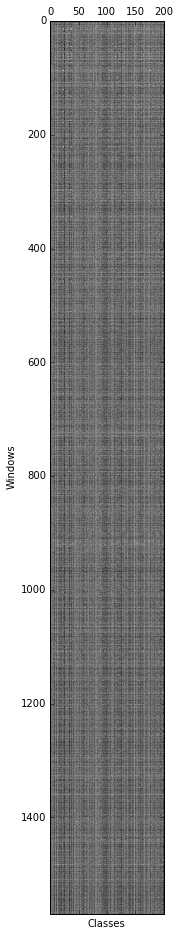

In [14]:
plt.gray()
plt.matshow(predictions_df.values)
plt.xlabel('Classes')
plt.ylabel('Windows')

In [15]:
max_s = predictions_df.max(0)
max_s.sort(ascending=False)
print(max_s[:10])

name
person          1.835771
bicycle         0.866111
unicycle        0.057079
motorcycle     -0.006121
banjo          -0.028209
turtle         -0.189831
electric fan   -0.206787
cart           -0.214238
lizard         -0.393518
helmet         -0.477941
dtype: float32


Top detection:
name
person             1.835771
swimming trunks   -1.150372
rubber eraser     -1.231106
turtle            -1.266037
plastic bag       -1.303266
dtype: float32

Second-best detection:
name
bicycle     0.866111
unicycle   -0.359138
scorpion   -0.811619
lobster    -0.982890
lamp       -1.096808
dtype: float32


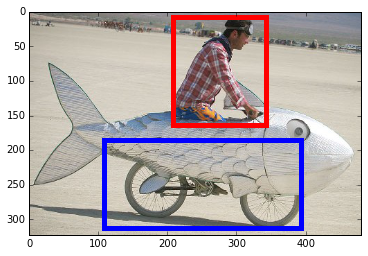

In [7]:
# Find, print, and display the top detections: person and bicycle.
i = predictions_df['person'].argmax()
j = predictions_df['bicycle'].argmax()

# Show top predictions for top detection.
f = pd.Series(df['prediction'].iloc[i], index=labels_df['name'])
print('Top detection:')
print(f.order(ascending=False)[:5])
print('')

# Show top predictions for second-best detection.
f = pd.Series(df['prediction'].iloc[j], index=labels_df['name'])
print('Second-best detection:')
print(f.order(ascending=False)[:5])

# Show top detection in red, second-best top detection in blue.
im = plt.imread('images/fish-bike.jpg')
plt.imshow(im)
currentAxis = plt.gca()

det = df.iloc[i]
coords = (det['xmin'], det['ymin']), det['xmax'] - det['xmin'], det['ymax'] - det['ymin']
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=5))

det = df.iloc[j]
coords = (det['xmin'], det['ymin']), det['xmax'] - det['xmin'], det['ymax'] - det['ymin']
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='b', linewidth=5))

In [16]:
def nms_detections(dets, overlap=0.3):
    """
    Non-maximum suppression: Greedily select high-scoring detections and
    skip detections that are significantly covered by a previously
    selected detection.

    This version is translated from Matlab code by Tomasz Malisiewicz,
    who sped up Pedro Felzenszwalb's code.

    Parameters
    ----------
    dets: ndarray
        each row is ['xmin', 'ymin', 'xmax', 'ymax', 'score']
    overlap: float
        minimum overlap ratio (0.3 default)

    Output
    ------
    dets: ndarray
        remaining after suppression.
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    ind = np.argsort(dets[:, 4])

    w = x2 - x1
    h = y2 - y1
    area = (w * h).astype(float)

    pick = []
    while len(ind) > 0:
        i = ind[-1]
        pick.append(i)
        ind = ind[:-1]

        xx1 = np.maximum(x1[i], x1[ind])
        yy1 = np.maximum(y1[i], y1[ind])
        xx2 = np.minimum(x2[i], x2[ind])
        yy2 = np.minimum(y2[i], y2[ind])

        w = np.maximum(0., xx2 - xx1)
        h = np.maximum(0., yy2 - yy1)

        wh = w * h
        o = wh / (area[i] + area[ind] - wh)

        ind = ind[np.nonzero(o <= overlap)[0]]

    return dets[pick, :]

In [17]:
scores = predictions_df['bicycle']
windows = df[['xmin', 'ymin', 'xmax', 'ymax']].values
dets = np.hstack((windows, scores[:, np.newaxis]))
nms_dets = nms_detections(dets)

scores: [ 0.86611092 -0.70051599 -1.34796309]


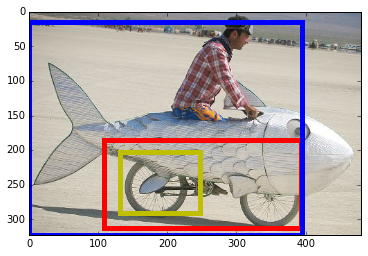

In [18]:
plt.imshow(im)
currentAxis = plt.gca()
colors = ['r', 'b', 'y']
for c, det in zip(colors, nms_dets[:3]):
    currentAxis.add_patch(
        plt.Rectangle((det[0], det[1]), det[2]-det[0], det[3]-det[1],
        fill=False, edgecolor=c, linewidth=5)
    )
print 'scores:', nms_dets[:3, 4]

In [11]:
!rm -rf _temp

This run was in GPU mode. For CPU mode detection, call `detect.py` without the `--gpu` argument.

Running this outputs a DataFrame with the filenames, selected windows, and their detection scores to an HDF5 file.
(We only ran on one image, so the filenames will all be the same.)

# 1570 regions were proposed with the R-CNN configuration of selective search. The number of proposals will vary from image to image based on its contents and size -- selective search isn't scale invariant.

In general, `detect.py` is most efficient when running on a lot of images: it first extracts window proposals for all of them, batches the windows for efficient GPU processing, and then outputs the results.
Simply list an image per line in the `images_file`, and it will process all of them.

Although this guide gives an example of R-CNN ImageNet detection, `detect.py` is clever enough to adapt to different Caffe models’ input dimensions, batch size, and output categories. You can switch the model definition and pretrained model as desired. Refer to `python detect.py --help` for the parameters to describe your data set. There's no need for hardcoding.

Anyway, let's now load the ILSVRC13 detection class names and make a DataFrame of the predictions. Note you'll need the auxiliary ilsvrc2012 data fetched by `data/ilsvrc12/get_ilsvrc12_aux.sh`.

Let's look at the activations.

Now let's take max across all windows and plot the top classes.

The top detections are in fact a person and bicycle.
Picking good localizations is a work in progress; we pick the top-scoring person and bicycle detections.

That's cool. Let's take all 'bicycle' detections and NMS them to get rid of overlapping windows.

Show top 3 NMS'd detections for 'bicycle' in the image and note the gap between the top scoring box (red) and the remaining boxes.

This was an easy instance for bicycle as it was in the class's training set. However, the person result is a true detection since this was not in the set for that class.

You should try out detection on an image of your own next!

(Remove the temp directory to clean up, and we're done.)